In [68]:
### Imports
import os
import sys
import numpy as np
import pandas as pd
import click
import logging
import pickle
import cv2
import resource
import random
from datetime import datetime
from pathlib import Path
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

# import supported models
from tensorflow.keras.applications import ResNet50, MobileNet, MobileNetV2

# import preprocessing functions for the models
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_input_mobile_net
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobile_net_v2

from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1 import set_random_seed
from tensorflow.compat.v1.keras.models import save_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [2]:
# get project path, and flag if script runs in a file
project_path = Path(os.getcwd(), os.pardir)
output_path = project_path / "output"
results_csv_path = output_path / 'results.csv'

# add project root to pythonpath
sys.path.insert(0, str(project_path / "src"))

# import custom packages
from utils.identify import *    
from utils.log import *
from utils.click_utils import conditionally_decorate
from set_cardgame.dataset import *

# setup logging
logger = setup_logger(level=logging.INFO, logfile=output_path / f"log_.txt")

logger.info("======")
logger.info(f"project_path: {project_path}")
logger.info(f"output_path: {output_path}")

# make results repeatable
seed = 42
random.seed(seed)  # python built-in pseudo-random generator
np.random.seed(seed)  # numpy pseudo-random generator
set_random_seed(seed)  # tensorflow pseudo-random generator

In [3]:
# name of first layer that had 100% validation score  
layer_name = "res3d_branch2a"

# initialize intermediate model
model_instance = ResNet50(include_top=False, weights='imagenet', pooling=None, input_shape=(96, 128, 3))
preprocess_input_function = preprocess_input_resnet50

# create new model and set outputs to the best desired layer  
intermediate_model = Model(inputs=model_instance.input, outputs=model_instance.get_layer(layer_name).output)
intermediate_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[categorical_accuracy])

/Users/salomon/miniconda3/envs/setdetection/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [69]:
# save the intermediate model
save_model(
    intermediate_model,
    output_path / f"resnet_{layer_name}_intermediate_model.h5",
    overwrite=True,
    include_optimizer=True,
    save_format='h5'
)

In [6]:
nr_images = 8100

# load training and validation data
X_train, y_train, X_val, y_val = load_dataset(nr_images=nr_images, output_path=None)

# apply preprocessing for the specified model
X_train = preprocess_input_function(X_train)
X_val = preprocess_input_function(X_val)

# nr samples
m_train = X_train.shape[0]
m_val = X_val.shape[0]

print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)
print("m_train:", m_train)
print("m_val:", m_val)

# generate image embeddings
X_train_embeddings = intermediate_model.predict(X_train)
X_val_embeddings = intermediate_model.predict(X_val)

# reshape embeddings to 2D
X_train_embeddings = X_train_embeddings.reshape(m_train, -1)
X_val_embeddings = X_val_embeddings.reshape(m_val, -1)

# fit model
clf = LogisticRegression(random_state=seed, solver='lbfgs', multi_class='multinomial').fit(X_train_embeddings, y_train)

train_score = clf.score(X_train_embeddings, y_train)
val_score = clf.score(X_val_embeddings, y_val)
logger.info(f"score for layer_name {layer_name}, train_score: {train_score:.4f}, val_score: {val_score:.4f}")

Found 243 images belonging to 81 classes.
Found 81 images belonging to 81 classes.
X_train.shape: (8100, 96, 128, 3)
X_val.shape: (81, 96, 128, 3)
m_train: 8100
m_val: 81


/Users/salomon/miniconda3/envs/setdetection/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [9]:
with open(output_path / f'clf_{layer_name}_{nr_images}.pkl', 'wb') as handle:
    pickle.dump(clf, handle)

### load model

In [46]:
with open(output_path / f'clf_{layer_name}_{nr_images}.pkl', 'rb') as handle:
    best_model = pickle.load(handle)

In [ ]:
# load training and validation data
X_test, y_test, X_val, y_val = load_dataset(nr_images=810, output_path=None)
m_test = X_test.shape[0]

# preprocessing
X_test = preprocess_input_function(X_test)

# generate image embeddings
X_test_embeddings = intermediate_model.predict(X_test).reshape(m_test, -1)

In [47]:
test_score = best_model.score(X_test_embeddings, y_test)
print(f"test_score:{test_score}")

test_score:1.0


In [63]:
test_image_orig = cv2.imread(str(project_path / "test_images" / "test1.png"))
test_image = np.expand_dims(test_image_orig, 0)
test_image = preprocess_input_function(test_image)
test_image = intermediate_model.predict(test_image).reshape(1, -1)
predicted_card_id = int(best_model.predict(test_image)[0])
df_meta, _ = load_metadata()
title = " ".join(list(df_meta[df_meta.card_id == predicted_card_id][['color', 'shape', 'fill', 'number']].drop_duplicates().values[0]))

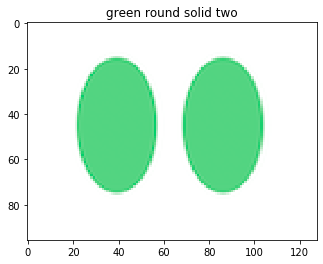

In [66]:
plt.imshow(test_image_orig)
plt.title(title)
plt.show()